# Density coordinate MKE and EKE

$$
    \overline{KE_i} = \underbrace{\frac{1}{2}\rho_0\overline{h_i}|\mathbf{\hat{u}_i}|^2}_{\text{MKE}_{i}} + \underbrace{\frac{1}{2}\rho_0\overline{h_i|\mathbf{u_i''}|^2}}_{\text{EKE}_{i}}
$$

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34629 Dashboard: /proxy/45893/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

lat_range = slice(-80,10)
lat_range_big =  slice(-80.05,10.1)


In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 1.23 s, sys: 118 ms, total: 1.34 s
Wall time: 7.64 s


In [7]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)


CPU times: user 372 ms, sys: 60.8 ms, total: 432 ms
Wall time: 5.75 s


# combine summed h_bar, uh_bar, vh_bar to find mean h_bar, vh_bar and uh_bar (and therefore u hat, v hat)

From script save_summed_SO_energy_terms.py

"""
Sums vh,uh and h binned into density bins in Southern Ocean for 1 year so that time averages can be taken
"""

    ###### Load modules

    ###### Standard modules
    import cosima_cookbook as cc
    import matplotlib.pyplot as plt
    import netCDF4 as nc
    import xarray as xr
    import numpy as np
    from dask.distributed import Client
    import cftime
    import glob
    import dask.array as dsa
    from cosima_cookbook import distributed as ccd
    ###### Ignore warnings
    import logging
    logging.captureWarnings(True)
    logging.getLogger('py.warnings').setLevel(logging.ERROR)


    if __name__ == '__main__':

    # Start a dask cluster with multiple cores
    client = Client(n_workers=8, local_directory='/scratch/x77/cy8964/dask_dump/dask_worker_space')
    # Load database
    session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

    # This script just sums binned quantities for a single year.

    #### get run count argument that was passed to python script ####
    import sys
    year = str(sys.argv[1])
    expt = '01deg_jra55v13_ryf9091'

    start_time = year + '-01-01'
    end_time= year + '-12-31'

    # reference density value:
    rho_0 = 1035.0
    # Note: change this range, so it matches the size of your contour arrays:
    ## FULL SO ##
    lat_range = slice(-70,-34.99)
    lat_range_big =  slice(-70.05,-34.90)

    #load coordinates
    yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
    yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
    xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)

    # Load saved binned energy for the 12 months of given year
    
    saved_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_saving_energy_terms_'
    chunky = {"time":1,"isopycnal_bins":5,"yt_ocean":218,"xt_ocean":400 }

    month = '01'
    h_binned = xr.open_dataset(saved_dir+'h_binned_'+year+'-'+month+'_test.nc', chunks = chunky).h_binned
    vh_binned = xr.open_dataset(saved_dir+'vh_binned_'+year+'-'+month+'_test.nc', chunks = chunky).vh_binned
    uh_binned = xr.open_dataset(saved_dir+'uh_binned_'+year+'-'+month+'_test.nc', chunks = chunky).uh_binned

    for i in np.arange(2,13):
        month = str(i).zfill(2)
        h_binned_i = xr.open_dataset(saved_dir+'h_binned_'+year+'-'+month+'_test.nc', chunks = chunky)
        h_binned_i = h_binned_i.h_binned

        vh_binned_i = xr.open_dataset(saved_dir+'vh_binned_'+year+'-'+month+'_test.nc', chunks = chunky)
        vh_binned_i = vh_binned_i.vh_binned

        uh_binned_i = xr.open_dataset(saved_dir+'uh_binned_'+year+'-'+month+'_test.nc', chunks = chunky)
        uh_binned_i = uh_binned_i.uh_binned

        h_binned = xr.concat([h_binned,h_binned_i], dim = 'time')
        vh_binned = xr.concat([vh_binned,vh_binned_i], dim = 'time')
        uh_binned = xr.concat([uh_binned,uh_binned_i], dim = 'time')
        
    # sum uh and save and delete
    uh_bar_sum = uh_binned.sum('time')
    uh_bar_sum=ccd.compute_by_block(uh_bar_sum)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'uh_bar_sum': uh_bar_sum})
    ds.to_netcdf(save_dir+'uh_bar_sum_'+year+'.nc')
    del uh_bar_sum

    # sum vh and save and delete
    vh_bar_sum = vh_binned.sum('time')
    vh_bar_sum=ccd.compute_by_block(vh_bar_sum)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'vh_bar_sum': vh_bar_sum})
    ds.to_netcdf(save_dir+'vh_bar_sum_'+year+'.nc')
    del vh_bar_sum

    # sum h and save and delete    
    h_bar_sum= h_binned.sum('time')
    h_bar_sum=ccd.compute_by_block(h_bar_sum)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'h_bar_sum': h_bar_sum})
    ds.to_netcdf(save_dir+'h_bar_sum_'+year+'.nc')



In [9]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
chunky = {"isopycnal_bins":5,"yt_ocean":218,"xt_ocean":400 }

In [10]:
%%time
year = '2170'
h_binned_bar = xr.open_dataset(save_dir+'h_bar_sum_2170.nc', chunks = chunky).h_bar_sum
h_binned_bar = xr.zeros_like(h_binned_bar)
h_binned_bar = h_binned_bar.expand_dims({"year":np.arange(2170,2180)})
uh_binned_bar = xr.zeros_like(h_binned_bar)
vh_binned_bar = xr.zeros_like(h_binned_bar)
u_bar = xr.zeros_like(h_binned_bar)


for i in np.arange(2171,2180):
    print(i)
    year = str(i)
    h_binned_bar_i = xr.open_dataset(save_dir+'h_bar_sum_'+year+'.nc', chunks = chunky).h_bar_sum

    vh_binned_bar_i = xr.open_dataset(save_dir+'vh_bar_sum_'+year+'.nc', chunks = chunky).vh_bar_sum
    uh_binned_bar_i = xr.open_dataset(save_dir+'uh_bar_sum_'+year+'.nc', chunks = chunky).uh_bar_sum
    u_bar_i = xr.open_dataset(save_dir+'u_sum_'+year+'.nc', chunks = chunky).u_sum

    h_binned_bar[i-2170,:,:,:] = h_binned_bar_i
    vh_binned_bar[i-2170,:,:,:] = vh_binned_bar_i
    uh_binned_bar[i-2170,:,:,:] = uh_binned_bar_i
    u_bar[i-2170,:,:,:] = u_bar_i

    
h_binned_bar = h_binned_bar.sum('year')/3650
uh_binned_bar = uh_binned_bar.sum('year')/3650
vh_binned_bar = vh_binned_bar.sum('year')/3650
u_bar = u_bar.sum('year')/3650


2171
2172
2173
2174
2175
2176
2177
2178
2179
CPU times: user 10.9 s, sys: 10.9 s, total: 21.8 s
Wall time: 1min 13s


In [12]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'u_bar': u_bar})
ds.to_netcdf(save_dir+'u_bar_10yr.nc')

CPU times: user 4.06 s, sys: 8.34 s, total: 12.4 s
Wall time: 30.1 s


### saving MKE stuff

In [12]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'h_bar': h_binned_bar})
ds.to_netcdf(save_dir+'h_bar_10yr.nc')

CPU times: user 4.5 s, sys: 4.57 s, total: 9.07 s
Wall time: 14.9 s


In [13]:
%%time
u_hat = uh_binned_bar/h_binned_bar/rho_0
u_hat = u_hat.where(u_hat!=np.inf).where(u_hat !=-np.inf).fillna(0)
v_hat = vh_binned_bar/h_binned_bar/rho_0
v_hat = v_hat.where(v_hat!=np.inf).where(v_hat !=-np.inf).fillna(0)

u_hat = u_hat.load()

CPU times: user 7.37 s, sys: 12.2 s, total: 19.6 s
Wall time: 22.6 s


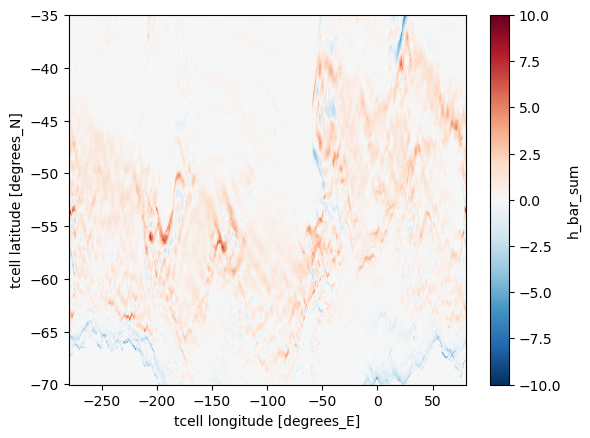

In [14]:
u_hat.sum('isopycnal_bins').plot(vmax = 10)

In [15]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'u_hat': u_hat})
ds.to_netcdf(save_dir+'u_hat_10yr.nc')

CPU times: user 31.4 ms, sys: 430 ms, total: 461 ms
Wall time: 461 ms


In [16]:
%%time
v_hat = v_hat.load()

CPU times: user 6.96 s, sys: 10.6 s, total: 17.6 s
Wall time: 20.6 s


In [17]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'v_hat': v_hat})
ds.to_netcdf(save_dir+'v_hat_10yr.nc')

CPU times: user 35.3 ms, sys: 470 ms, total: 506 ms
Wall time: 604 ms


In [11]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'vh_bar': vh_binned_bar})
ds.to_netcdf(save_dir+'vh_bar_10yr.nc')

CPU times: user 5.42 s, sys: 6.55 s, total: 12 s
Wall time: 29.5 s


In [8]:
v_hat = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/v_hat_10yr.nc').v_hat
v_hat = v_hat.load()
u_hat = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/u_hat_10yr.nc').u_hat
u_hat = u_hat.load()
h_bar = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/h_bar_10yr.nc').h_bar
h_bar = h_bar.load()

In [19]:
%%time
MKE = 0.5*rho_0*h_bar*(u_hat**2+v_hat**2)
MKE = MKE.load()

CPU times: user 398 ms, sys: 463 ms, total: 861 ms
Wall time: 814 ms


In [20]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'MKE': MKE})
ds.to_netcdf(save_dir+'MKE_10yr.nc')

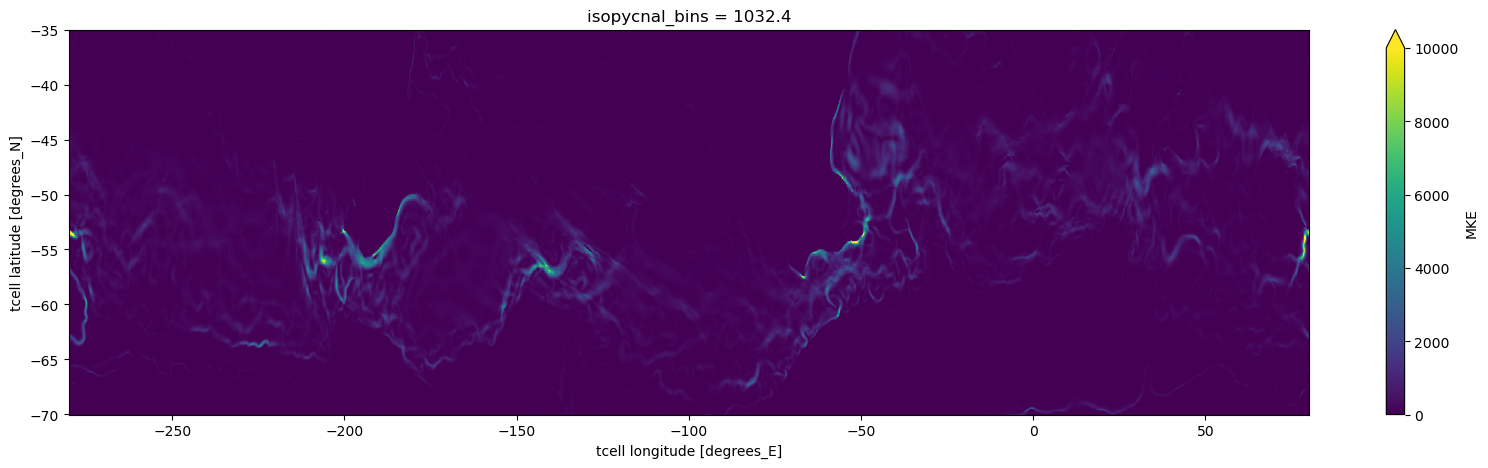

In [22]:
MKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MKE_10yr.nc').MKE
fig = plt.figure(figsize = (20,5))
MKE.sel(isopycnal_bins = 1032.4, method = 'nearest').plot(vmax = 10000)

## EKE combing years from script saved_summed_EKE.py

    """
    Sums EKE for 1 year in Southern Ocean so that longer term average can be calculated
    """

    # Load modules

    # Standard modules
    import cosima_cookbook as cc
    import matplotlib.pyplot as plt
    import netCDF4 as nc
    import xarray as xr
    import numpy as np
    from dask.distributed import Client
    import cftime
    import glob
    import dask.array as dsa
    from cosima_cookbook import distributed as ccd
    # Ignore warnings
    import logging
    logging.captureWarnings(True)
    logging.getLogger('py.warnings').setLevel(logging.ERROR)


    if __name__ == '__main__':

    # Start a dask cluster with multiple cores
    client = Client(n_workers=8, local_directory='/scratch/x77/cy8964/dask_dump/dask_worker_space')
    # Load database
    session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

    # This script just sums binned quantities for a single year.

    #### get run count argument that was passed to python script ####
    import sys
    year = str(sys.argv[1])
    expt = '01deg_jra55v13_ryf9091'

    start_time = year + '-01-01'
    end_time= year + '-12-31'

    # reference density value:
    rho_0 = 1035.0
    # Note: change this range, so it matches the size of your contour arrays:
    ## FULL SO ##
    lat_range = slice(-70,-34.99)
    lat_range_big =  slice(-70.05,-34.90)

    #load coordinates
    yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
    yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
    xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)

    # load 1 year of data
    saved_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_saving_energy_terms_'
    chunky = {"time":1,"isopycnal_bins":5,"yt_ocean":218,"xt_ocean":400 }

    month = '01'
    h_binned = xr.open_dataset(saved_dir+'h_binned_'+year+'-'+month+'_test.nc', chunks = chunky).h_binned
    vh_binned = xr.open_dataset(saved_dir+'vh_binned_'+year+'-'+month+'_test.nc', chunks = chunky).vh_binned
    uh_binned = xr.open_dataset(saved_dir+'uh_binned_'+year+'-'+month+'_test.nc', chunks = chunky).uh_binned

    for i in np.arange(2,13):
        month = str(i).zfill(2)
        h_binned_i = xr.open_dataset(saved_dir+'h_binned_'+year+'-'+month+'_test.nc', chunks = chunky)
        h_binned_i = h_binned_i.h_binned

        vh_binned_i = xr.open_dataset(saved_dir+'vh_binned_'+year+'-'+month+'_test.nc', chunks = chunky)
        vh_binned_i = vh_binned_i.vh_binned

        uh_binned_i = xr.open_dataset(saved_dir+'uh_binned_'+year+'-'+month+'_test.nc', chunks = chunky)
        uh_binned_i = uh_binned_i.uh_binned

        h_binned = xr.concat([h_binned,h_binned_i], dim = 'time')
        vh_binned = xr.concat([vh_binned,vh_binned_i], dim = 'time')
        uh_binned = xr.concat([uh_binned,uh_binned_i], dim = 'time')

    #load 10 year means of data
    chunky2 = {"isopycnal_bins":5,"yt_ocean":218,"xt_ocean":400 }
    saved_dir2 = '/g/data/x77/cy8964/Post_Process/New_SO/'
    h_bar = xr.open_dataset(saved_dir2+'h_bar_10yr.nc', chunks = chunky2).h_bar
    u_hat = xr.open_dataset(saved_dir2+'u_hat_10yr.nc', chunks = chunky2).u_hat
    v_hat = xr.open_dataset(saved_dir2+'v_hat_10yr.nc', chunks = chunky2).v_hat

    # define u,v
    
    u = uh_binned/h_binned/rho_0
    u = u.where(u!=np.inf).where(u !=-np.inf).fillna(0)
    v = vh_binned/h_binned/rho_0
    v = v.where(v!=np.inf).where(v !=-np.inf).fillna(0)

    # define primed quantities
    u_primeprime = u-u_hat
    v_primeprime = v-v_hat

    EKE = 0.5*(h_binned*(u_primeprime**2+v_primeprime**2)).sum('time') 
    EKE = ccd.compute_by_block(EKE)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'EKE': EKE})
    ds.to_netcdf(save_dir+'EKE_sum_'+year+'.nc')

In [8]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
chunky = {"isopycnal_bins":5,"yt_ocean":218,"xt_ocean":400 }

In [9]:
%%time
year = '2170'
EKE = xr.open_dataset(save_dir+'EKE_sum_'+year+'.nc', chunks = chunky).EKE
EKE  = xr.zeros_like(EKE )
EKE  = EKE.expand_dims({"year":np.arange(2170,2180)})

for i in np.arange(2170,2171):
    print(i)
    year = str(i)
    EKE_i = xr.open_dataset(save_dir+'EKE_sum_'+year+'.nc', chunks = chunky).EKE

    EKE[i-2170,:,:,:] = EKE_i
    
EKE = rho_0*EKE.sum('year')/3650*10

2170
CPU times: user 1.24 s, sys: 851 ms, total: 2.1 s
Wall time: 6.45 s


In [10]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'EKE': EKE})
ds.to_netcdf(save_dir+'EKE_1yr.nc')

CPU times: user 2.09 s, sys: 620 ms, total: 2.71 s
Wall time: 9.87 s


In [9]:
%%time
year = '2170'
EPE = xr.open_dataset(save_dir+'EPE_sum_'+year+'_no_g.nc', chunks = chunky).EPE
EPE  = xr.zeros_like(EPE )
EPE  = EPE.expand_dims({"year":np.arange(2170,2180)})

for i in np.arange(2170,2180):
    print(i)
    year = str(i)
    EPE_i = xr.open_dataset(save_dir+'EPE_sum_'+year+'_no_g.nc', chunks = chunky).EPE

    EPE[i-2170,:,:,:] = EPE_i
    
EPE = EPE.sum('year')/3650


2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
CPU times: user 10.6 s, sys: 8.35 s, total: 18.9 s
Wall time: 1min 6s


In [10]:
%%time
## define isopycnal bins   
isopycnal_bins_sigma1 = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
## since bins are edges of bins, define middle densities to be used in 
middle_density = (isopycnal_bins_sigma1+ np.roll(isopycnal_bins_sigma1, -1))/2
middle_density[0]=1028.5
middle_density[-2]=1034.5
middle_density[-1]=1035

## define g primes - set g_prime[0] to be g
g_prime = g*(middle_density - np.roll(middle_density, 1))/rho_0
g_prime[0]=g
g_prime = xr.DataArray(g_prime, coords = [isopycnal_bins_sigma1], dims = ['isopycnal_bins'], name = 'g_prime')
                                             

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 1.64 ms


In [11]:
EPE = EPE*g_prime

In [12]:
%%time
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'EPE': EPE})
ds.to_netcdf(save_dir+'EPE_10yr_fulldepth.nc')

CPU times: user 5.23 s, sys: 5.59 s, total: 10.8 s
Wall time: 18.8 s


In [11]:
%xdel EKE

In [12]:
EKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/EKE_10yr.nc').EKE
EKE = EKE.load()

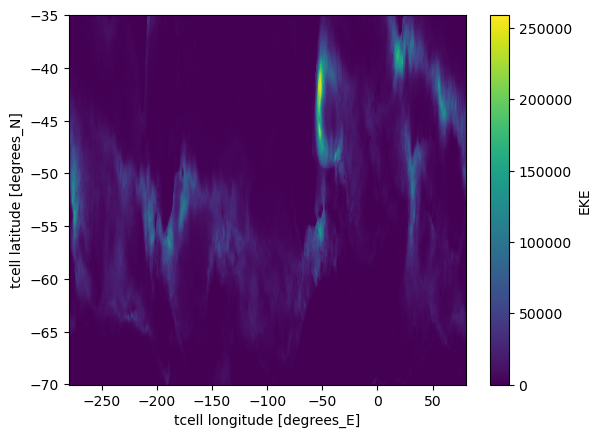

In [13]:
EKE.sum('isopycnal_bins').plot()

In [17]:
rho = 1032.4

Text(0.5, 1.0, 'integrated over all depths')

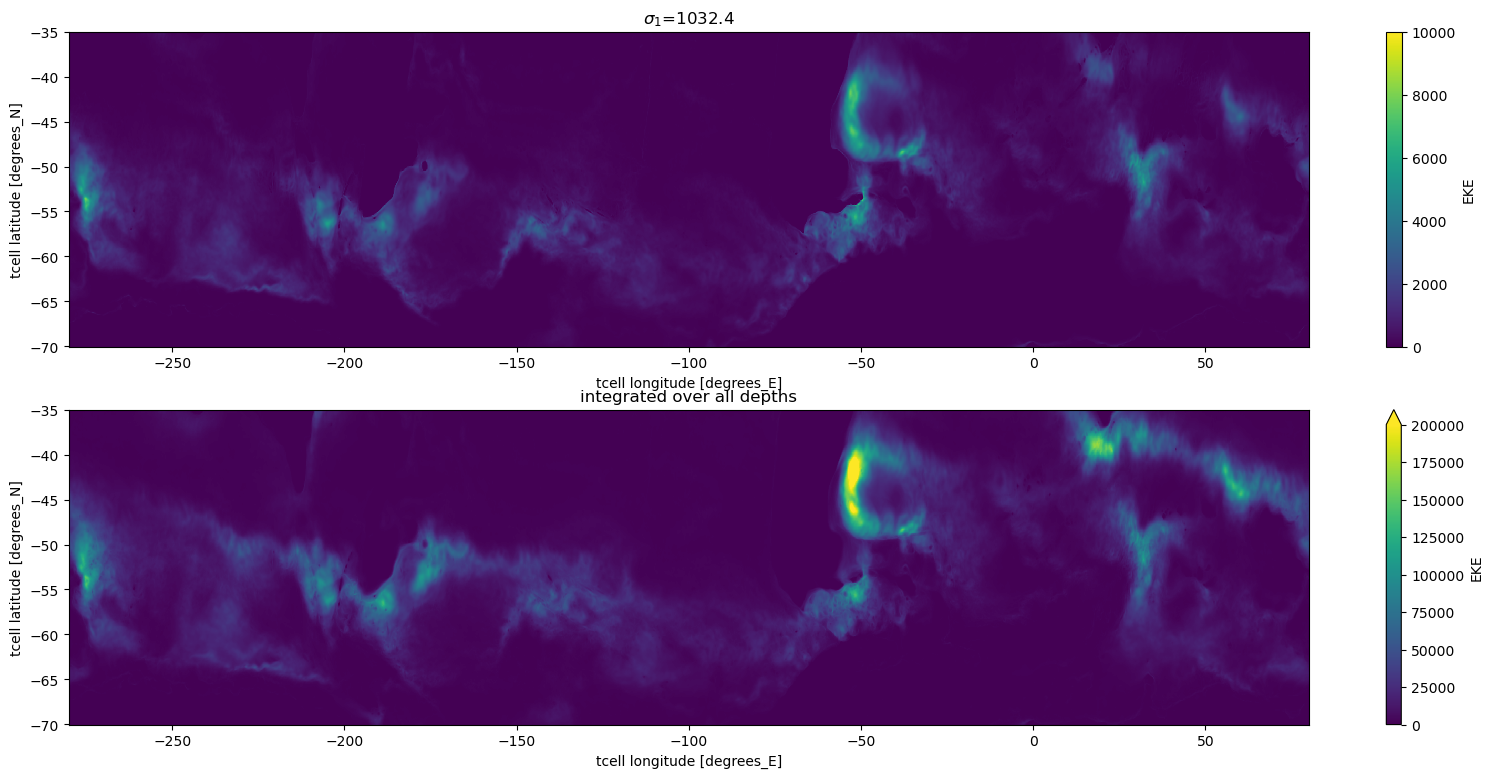

In [18]:
fig,axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20,9))

EKE.sel(isopycnal_bins =rho, method = 'nearest').plot(ax = axes[0], vmax = 10000)
EKE.sum('isopycnal_bins').plot(ax = axes[1], vmax = 200000)
axes[0].set_title('$\sigma_1$=1032.4')
axes[1].set_title('integrated over all depths')